In [13]:
# Load packages

# General math packages
import numpy as np
from scipy.integrate import odeint
import math

# Visualization
import matplotlib.pyplot as plt

# Data Science
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from scipy.optimize import curve_fit

## Create model for pendulum behaviour + generate data

In [8]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Function that returns dtheta/dt.
def model(theta, t, bm, l):
    g = 9.81
    theta1 = theta[0]
    theta2 = theta[1]
    dtheta1_dt = theta2
    dtheta2_dt = -(bm) * theta2 - (g / l) * math.sin(theta1)
    dtheta_dt = [dtheta1_dt, dtheta2_dt]
    return dtheta_dt


In [32]:
# https://skill-lync.com/student-projects/Simulation-of-movement-of-Simple-Pendulum-using-Python-95388
# Inputs
b = 0.5
l = 1
m = 1
bm = b/m
actual_params = [b/m, l]
actual_theta_0 = [math.pi/2, 0] # [math.pi/2, 0]
t_min = 0
t_max = 5
t_step = 0.05
t = np.arange(t_min, t_max + t_step, t_step)

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

In [34]:
# Generate noise
noise_sd = 0
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

In [35]:
# Generate training dataset

# Adjusting the time range
t_max_new = 0.75  # Set the maximum time to 0.75 seconds
t_train = np.arange(t_min, t_max_new + t_step, t_step)

# Finding the index corresponding to the first second
index_train = int(t_max_new / t_step) + 1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_train = actual_theta[:index_train]

## Traditional Machine Learning

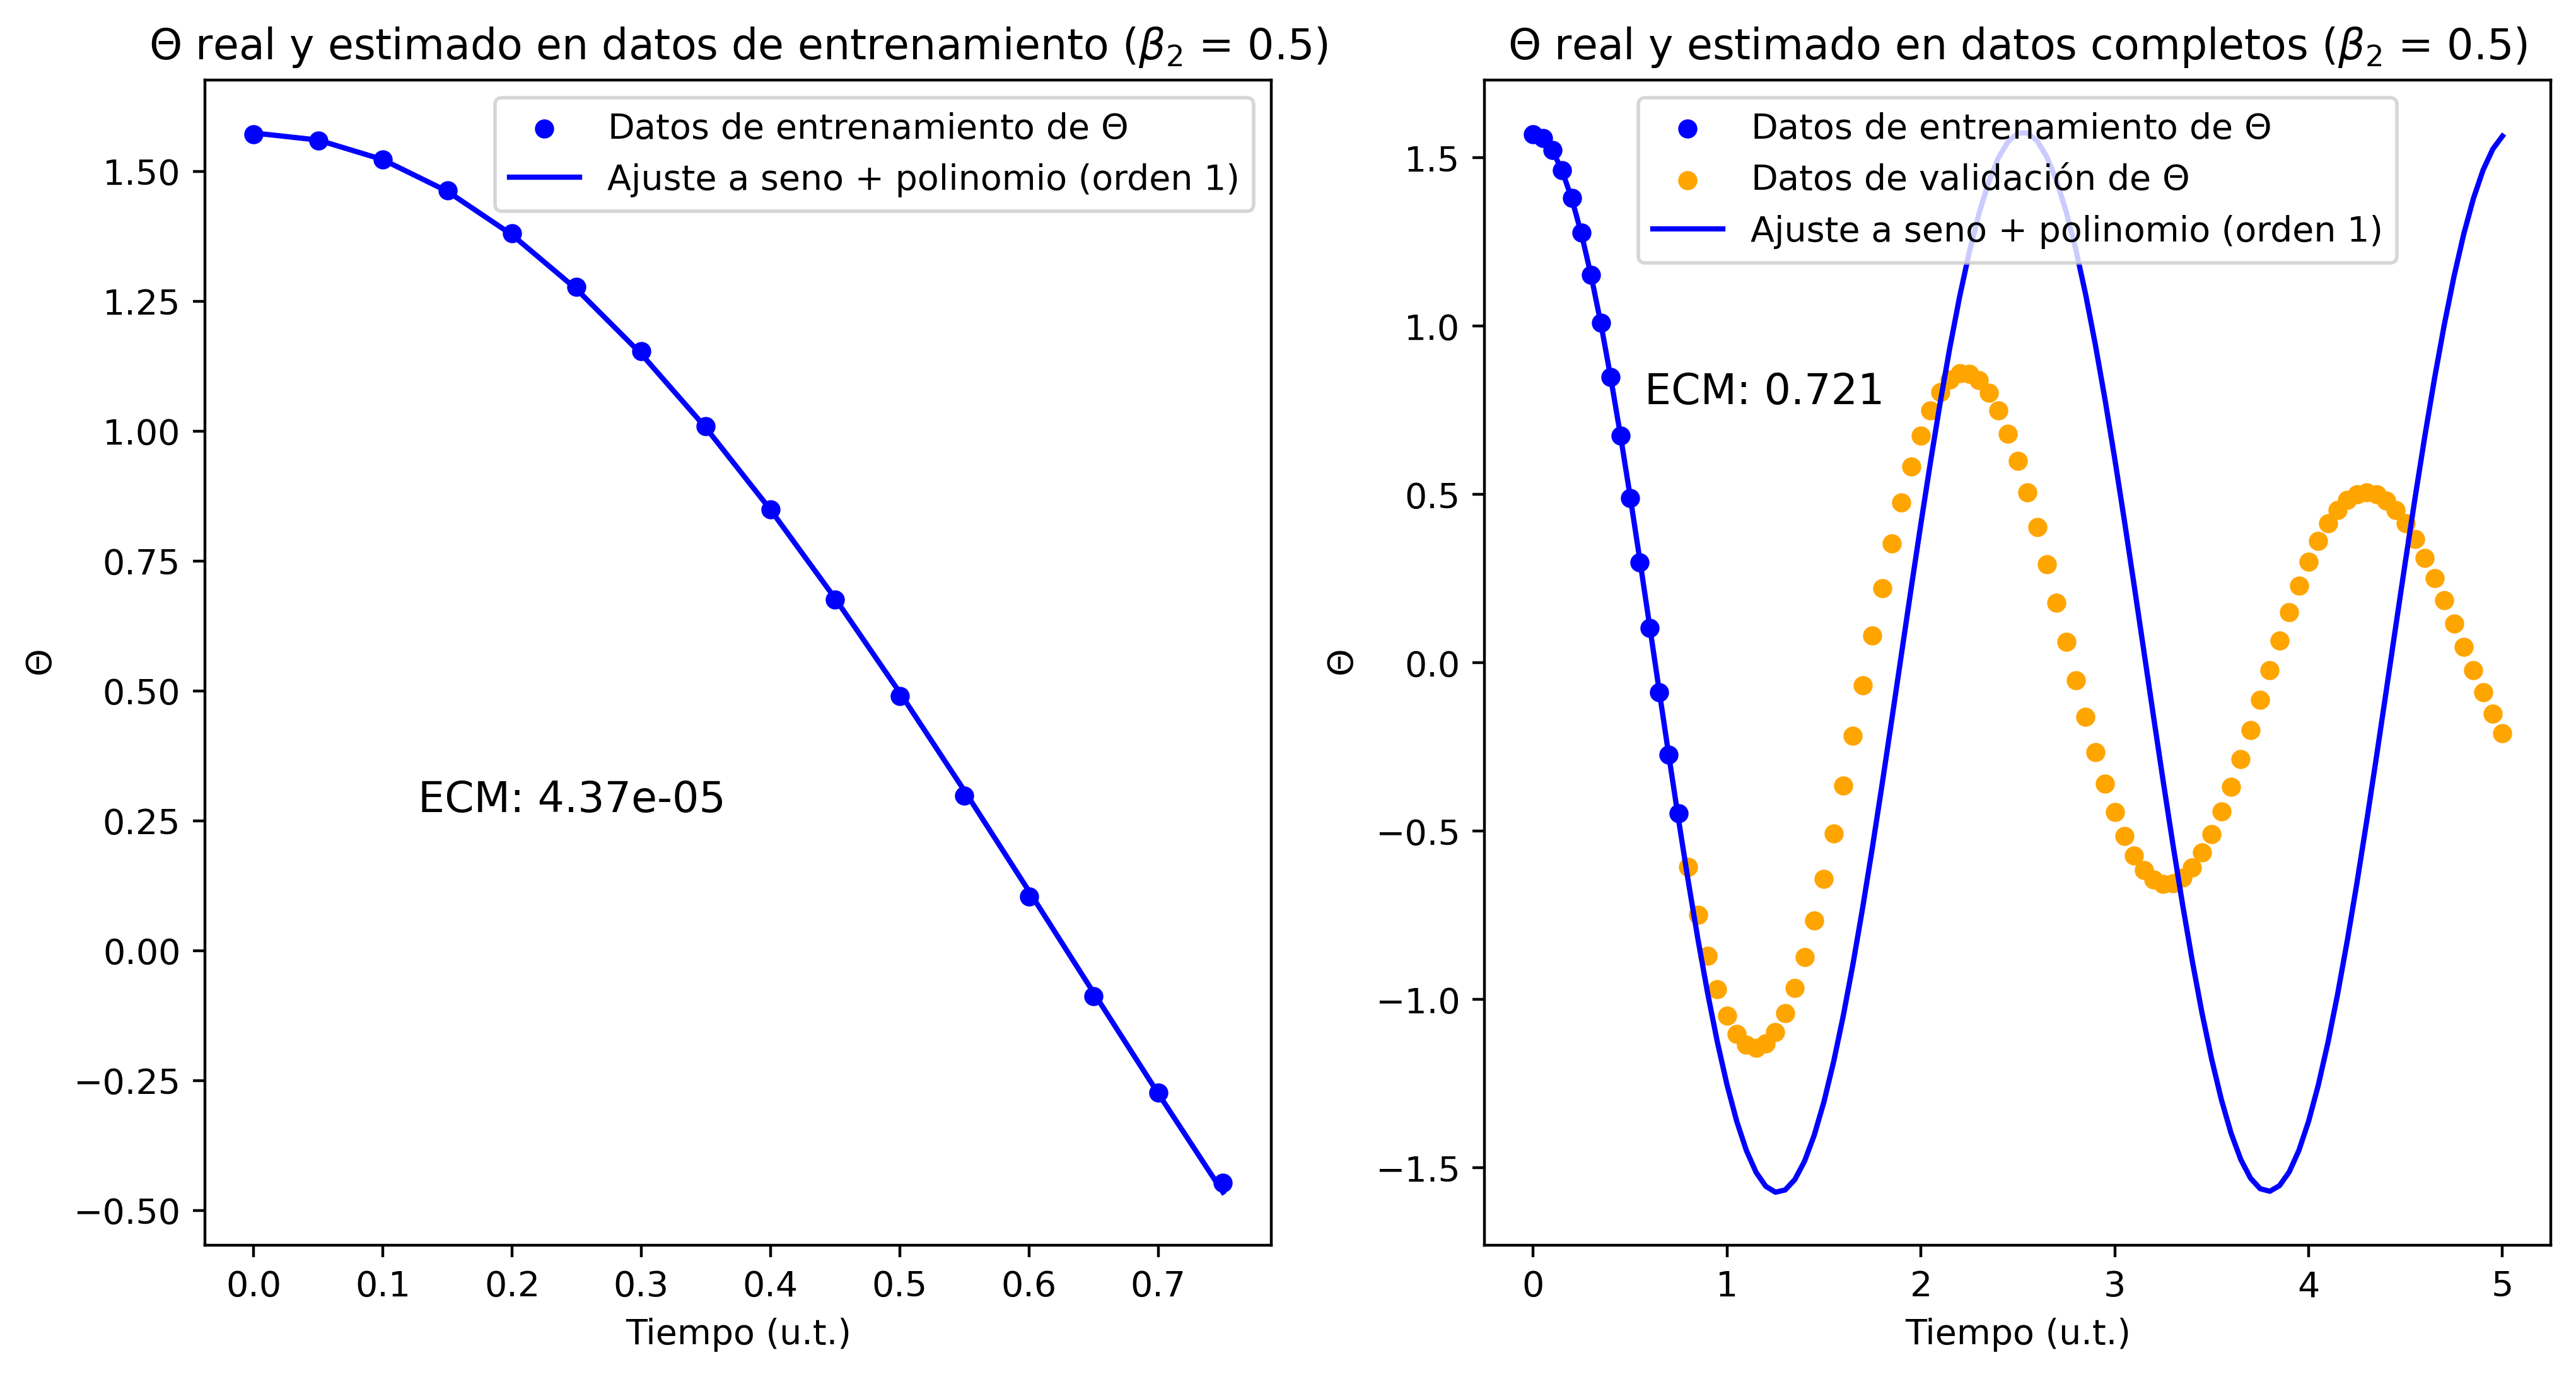

In [24]:
# Program mode
mode = 'polysin' # only_sin, only_poly, polysin
if mode == 'only_poly':
    # this is only poly function
    sin_param = 0
    poly_degree = 3
    label = f'Ajuste a polinomio (orden {poly_degree})'
elif mode == 'only_sin':
    # this is only sin function
    sin_param = 1
    poly_degree = 0
    label = 'Ajuste a seno'
elif mode == 'polysin':
    # poly + sine
    sin_param = 1
    poly_degree = 1
    label = f'Ajuste a seno + polinomio (orden {poly_degree})'

# Define a custom function to model a1 * np.sin(a2 * x + a3)
def custom_sin(x, a1, a2, a3):
    return sin_param * a1 * np.sin(a2 * x + a3)

# Use curve_fit to find the best a and b
params, _ = curve_fit(custom_sin, t_train, actual_theta_noisy_train[:, 0])
a1, a2, a3 = params

# Create polynomial features of a desired degree (e.g., degree=0 for cubic)
degree = poly_degree
poly = PolynomialFeatures(degree=degree)
t_train_poly = poly.fit_transform(t_train.reshape(-1, 1))

# Add the custom sine feature
sin_feature = a1 * np.sin(a2 * t_train + a3).reshape(-1, 1)

# Combine polynomial features and sine feature
t_train_combined = np.hstack((t_train_poly, sin_feature))

# Train the linear regression model
polysin_model = LinearRegression()
polysin_model.fit(t_train_combined, actual_theta_noisy_train[:, 0])

# Predict in training dataset using the trained model
t_fit_train = np.linspace(min(t_train), max(t_train), 16).reshape(-1, 1)
t_fit_poly_train = poly.transform(t_fit_train)
sin_feature_fit_train = a1 * np.sin(a2 * t_fit_train + a3).reshape(-1, 1)
t_fit_combined = np.hstack((t_fit_poly_train, sin_feature_fit_train))
theta_fit_train = polysin_model.predict(t_fit_combined)

mse_train = np.mean((actual_theta_train[:, 0] - theta_fit_train) ** 2)

# Predict using the trained model
t_fit = np.linspace(min(t_train), max(t), 101).reshape(-1, 1)
t_fit_poly = poly.transform(t_fit)
sin_feature_fit = a1 * np.sin(a2 * t_fit + a3).reshape(-1, 1)
t_fit_combined = np.hstack((t_fit_poly, sin_feature_fit))
theta_fit = polysin_model.predict(t_fit_combined)

mse_test = np.mean((actual_theta[:, 0] - theta_fit) ** 2)

# Plot the results
plt.figure(figsize=(12, 6), dpi=400)
plt.subplot(1, 2, 1)
plt.scatter(t_train, actual_theta_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t_fit_train, theta_fit_train, color='blue', label=label)
plt.text(0.2, 0.4, f'ECM: {mse_train:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.title(r'$\Theta$ real y estimado en datos de entrenamiento ' r'$(\beta_2 $' f' = {b})')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.scatter(t_train, actual_theta_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.scatter(t[16:], actual_theta[16:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.plot(t_fit, theta_fit, color='blue', label=label)
plt.text(0.15, 0.75, f'ECM: {mse_test:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.title(r'$\Theta$ real y estimado en datos completos ' r'$(\beta_2 $' f' = {b})')
plt.grid(False)

plt.show()

## Physics Informed Machine Learning

In [25]:
# Loss function
def loss_function(params, theta_0, t, actual_theta):
    bm, l = params
    predicted_theta = odeint(model, theta_0, t, args=(bm, l,))
    return np.mean((predicted_theta[:,0] - actual_theta[:,0]) ** 2) # + np.mean((predicted_theta[:,1] - np.gradient(predicted_theta[:,0])) ** 2)

# Gradient function
def gradient(params, theta_0, t, actual_theta):
    eps = 1e-5
    grad = np.zeros_like(params)
    for i in range(len(params)):
        params_plus_eps = params.copy()
        params_plus_eps[i] += eps
        params_minus_eps = params.copy()
        params_minus_eps[i] -= eps
        grad[i] = (loss_function(params_plus_eps, theta_0, t, actual_theta) - 
                   loss_function(params_minus_eps, theta_0, t, actual_theta)) / (2 * eps)
    return grad

# Gradient descent function
def gradient_descent(theta_0, t, actual_theta, initial_params, learning_rate=0.01, max_iters=500000, tol=1e-7):
    params = initial_params.copy()
    for i in range(max_iters):
        grad = gradient(params, theta_0, t, actual_theta)
        params -= learning_rate * grad
        if np.linalg.norm(grad) < tol:
            print(f"Converged after {i+1} iterations.")
            break
    return params

In [26]:
# Initial parameters for gradient descent
initial_params = np.array([0.3, 0.8])

# Run gradient descent
estimated_params = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_params)
print("Estimated Parameters:", estimated_params)

# Function to simulate the system with estimated parameters
def simulate_system(theta_0, t, estimated_params):
    estimated_theta = odeint(model, theta_0, t, args=tuple(estimated_params))
    return estimated_theta

# Simulate the system with estimated parameters
estimated_theta = simulate_system(actual_theta_0, t, estimated_params)

# Calculate mean squared difference
squared_diff = np.square(actual_theta[:, 0] - estimated_theta[:, 0])
mean_squared_diff = np.mean(squared_diff)
print("Mean Squared Difference:", mean_squared_diff)

Converged after 196942 iterations.
Estimated Parameters: [0.49997819 1.00000482]
Mean Squared Difference: 3.694623742222075e-10


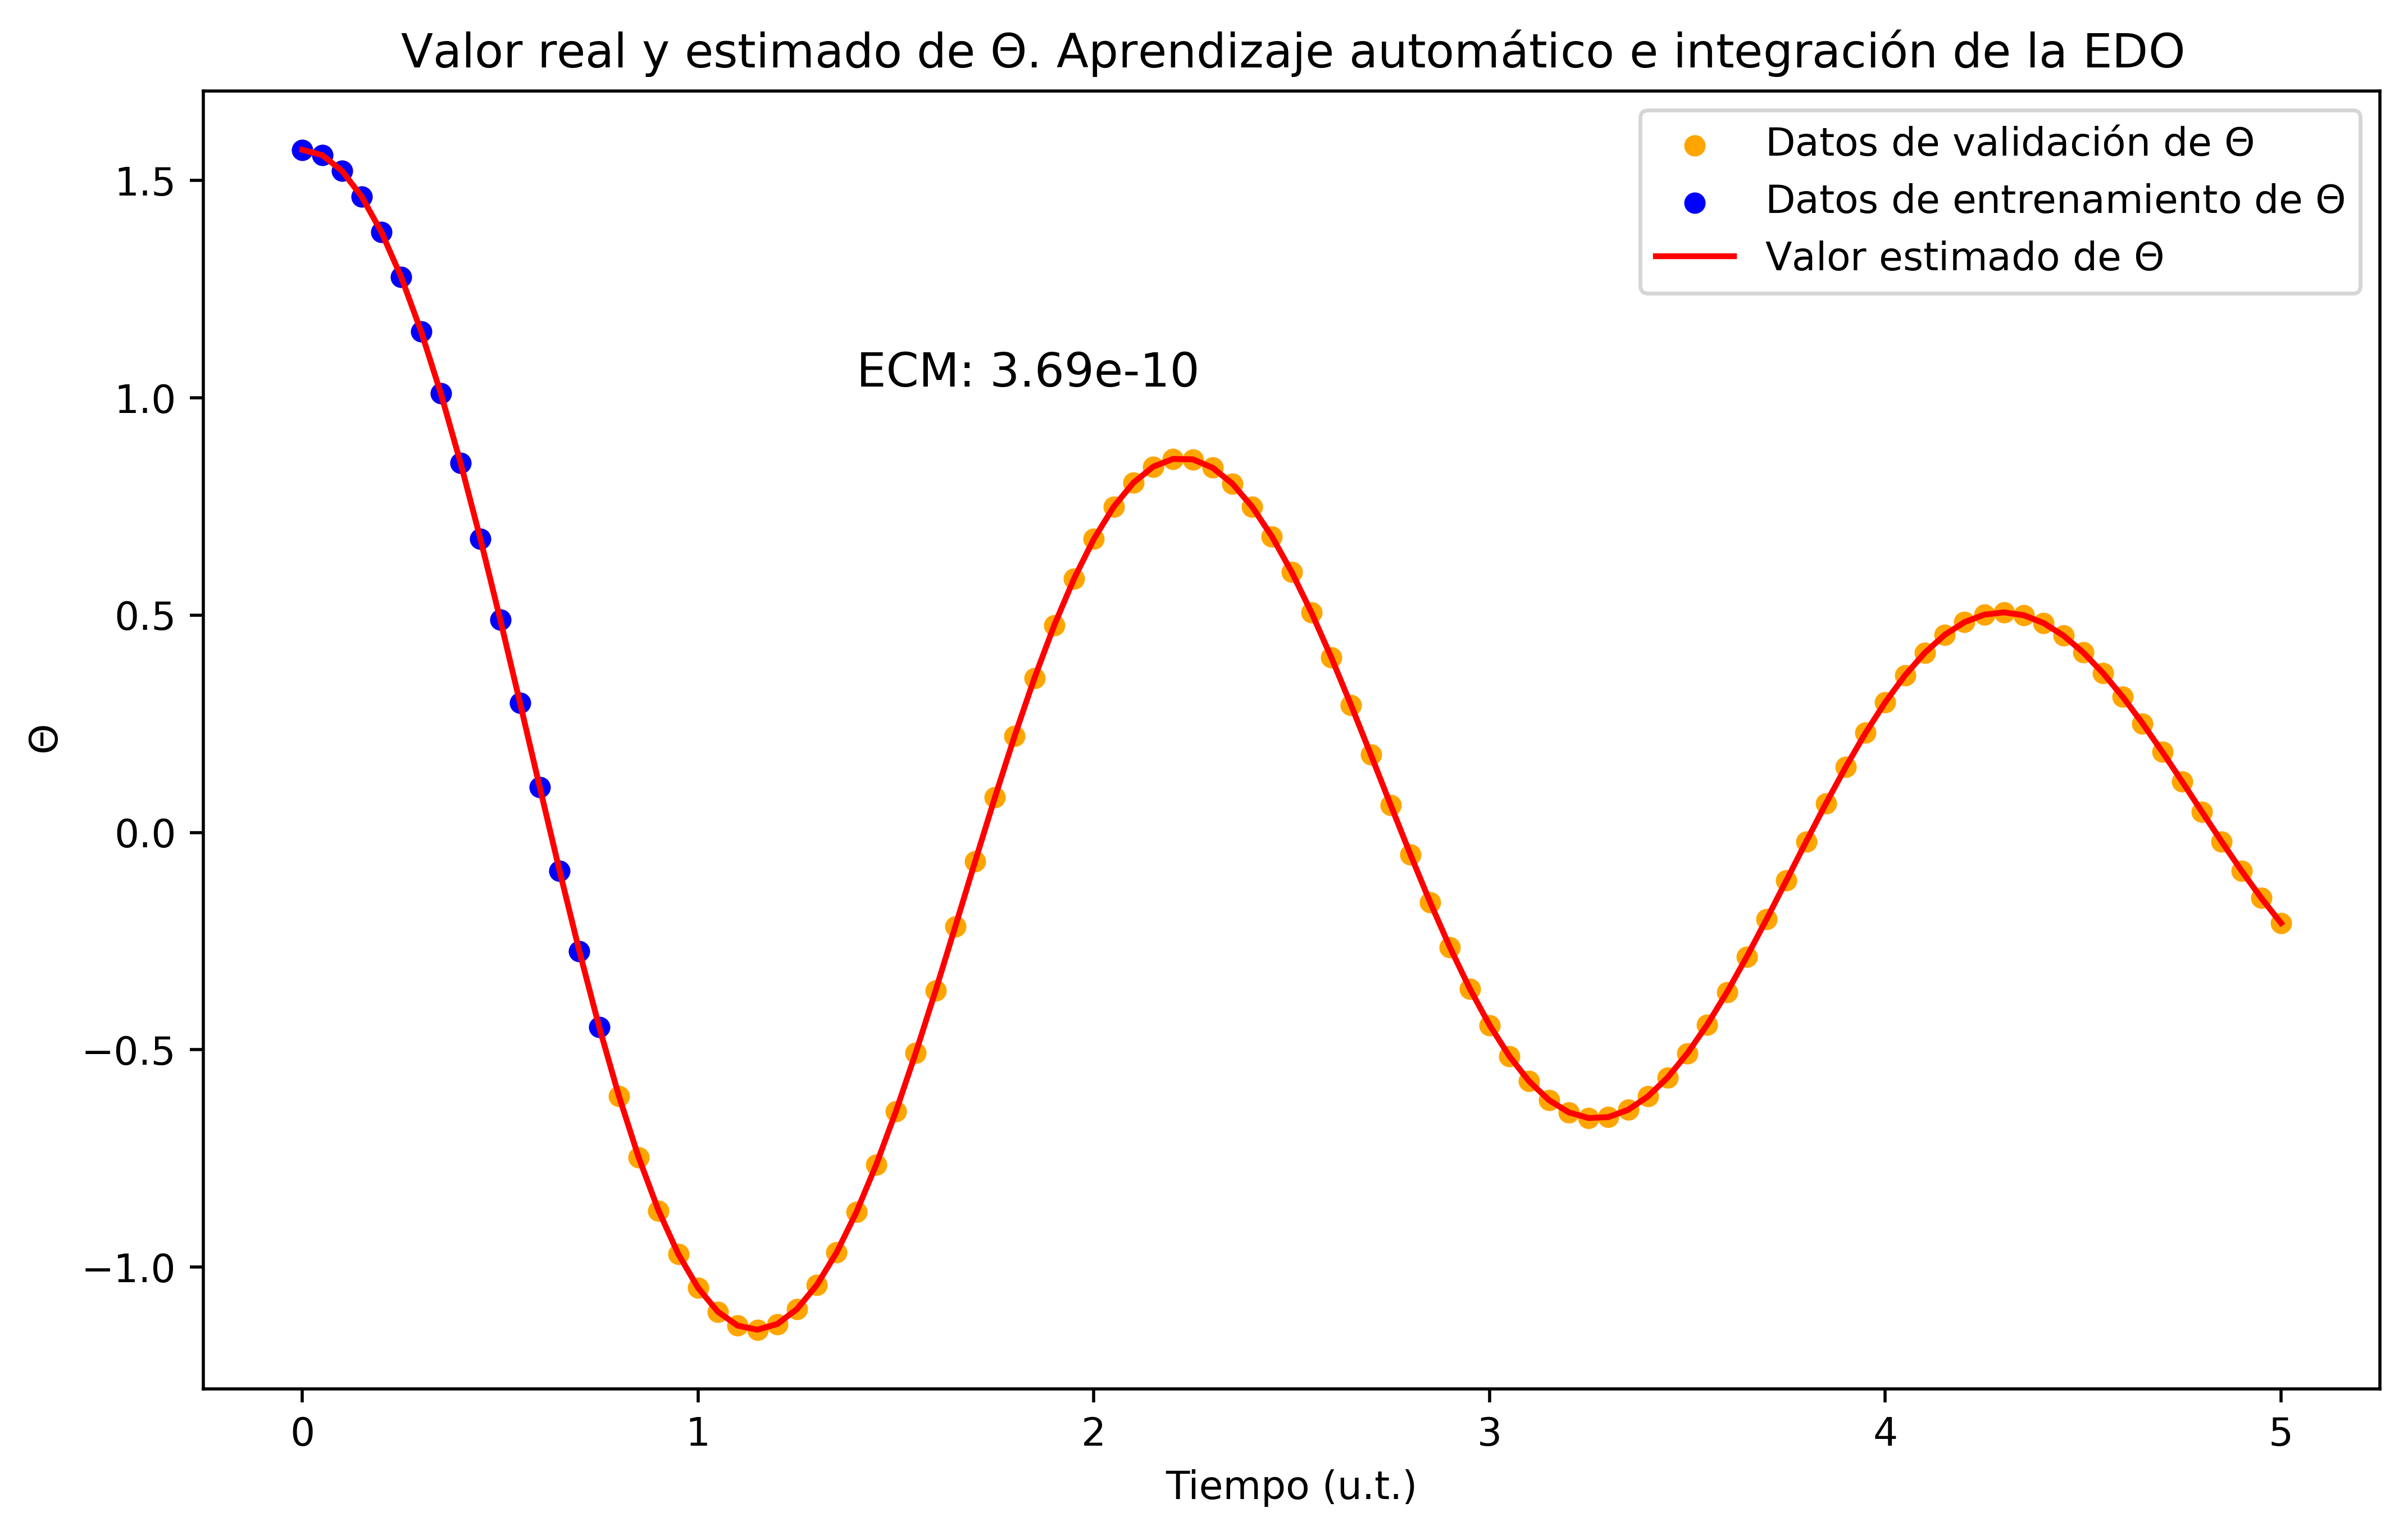

In [27]:
# Plotting
plt.figure(figsize=(10, 6), dpi = 500)
plt.scatter(t, actual_theta[:, 0], label=r'Datos de validación de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train[:, 0], label=r'Datos de entrenamiento de $\Theta$', s=20, color = 'blue')
plt.plot(t, estimated_theta[:, 0], label=r'Valor estimado de $\Theta$', color='red')

# Annotate plot with mean squared difference
plt.text(0.3, 0.8, f'ECM: {mean_squared_diff:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.title(r'Valor real y estimado de $\Theta$. Aprendizaje automático e integración de la EDO')
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.grid(False)
plt.show()

In [36]:
# Function to simulate the system with estimated parameters
def simulate_system(theta_0, t, estimated_params):
    estimated_theta = odeint(model, theta_0, t, args=tuple(estimated_params))
    return estimated_theta

## Smaller noise

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

# Generate noise
noise_sd = 0.05
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Initial parameters for gradient descent
initial_params = np.array([0.3, 0.8])

# Run gradient descent
estimated_params = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_params)

# Simulate the system with estimated parameters
estimated_theta05 = simulate_system(actual_theta_0, t, estimated_params)
actual_theta_noisy_train05 = actual_theta_noisy_train

## Bigger noise

# Actual theta values (assuming these are measured data)
actual_theta = odeint(model, actual_theta_0, t, args=(actual_params[0], actual_params[1],))

# Generate noise
noise_sd = 0.1
np.random.seed(seed=42) # this will be the seed for the rest of the notebook to ensure replicability
noise0 = np.random.normal(0, noise_sd, len(actual_theta[:,0]))
noise1 = np.random.normal(0, noise_sd, len(actual_theta[:,1]))

# Adding noise to the data
actual_theta_noisy = np.copy(actual_theta)
actual_theta_noisy[:, 0] = actual_theta_noisy[:, 0] + noise0
actual_theta_noisy[:, 1] = actual_theta_noisy[:, 1] + noise1

# Slicing the actual_theta_noisy array to include only the first 0.75 seconds of data
actual_theta_noisy_train = actual_theta_noisy[:index_train]

# Initial parameters for gradient descent
initial_params = np.array([0.3, 0.8])

# Run gradient descent
estimated_params = gradient_descent(actual_theta_0, t_train, actual_theta_noisy_train, initial_params)

# Simulate the system with estimated parameters
estimated_theta10 = simulate_system(actual_theta_0, t, estimated_params)
actual_theta_noisy_train10 = actual_theta_noisy_train

Converged after 3492 iterations.
Converged after 3323 iterations.


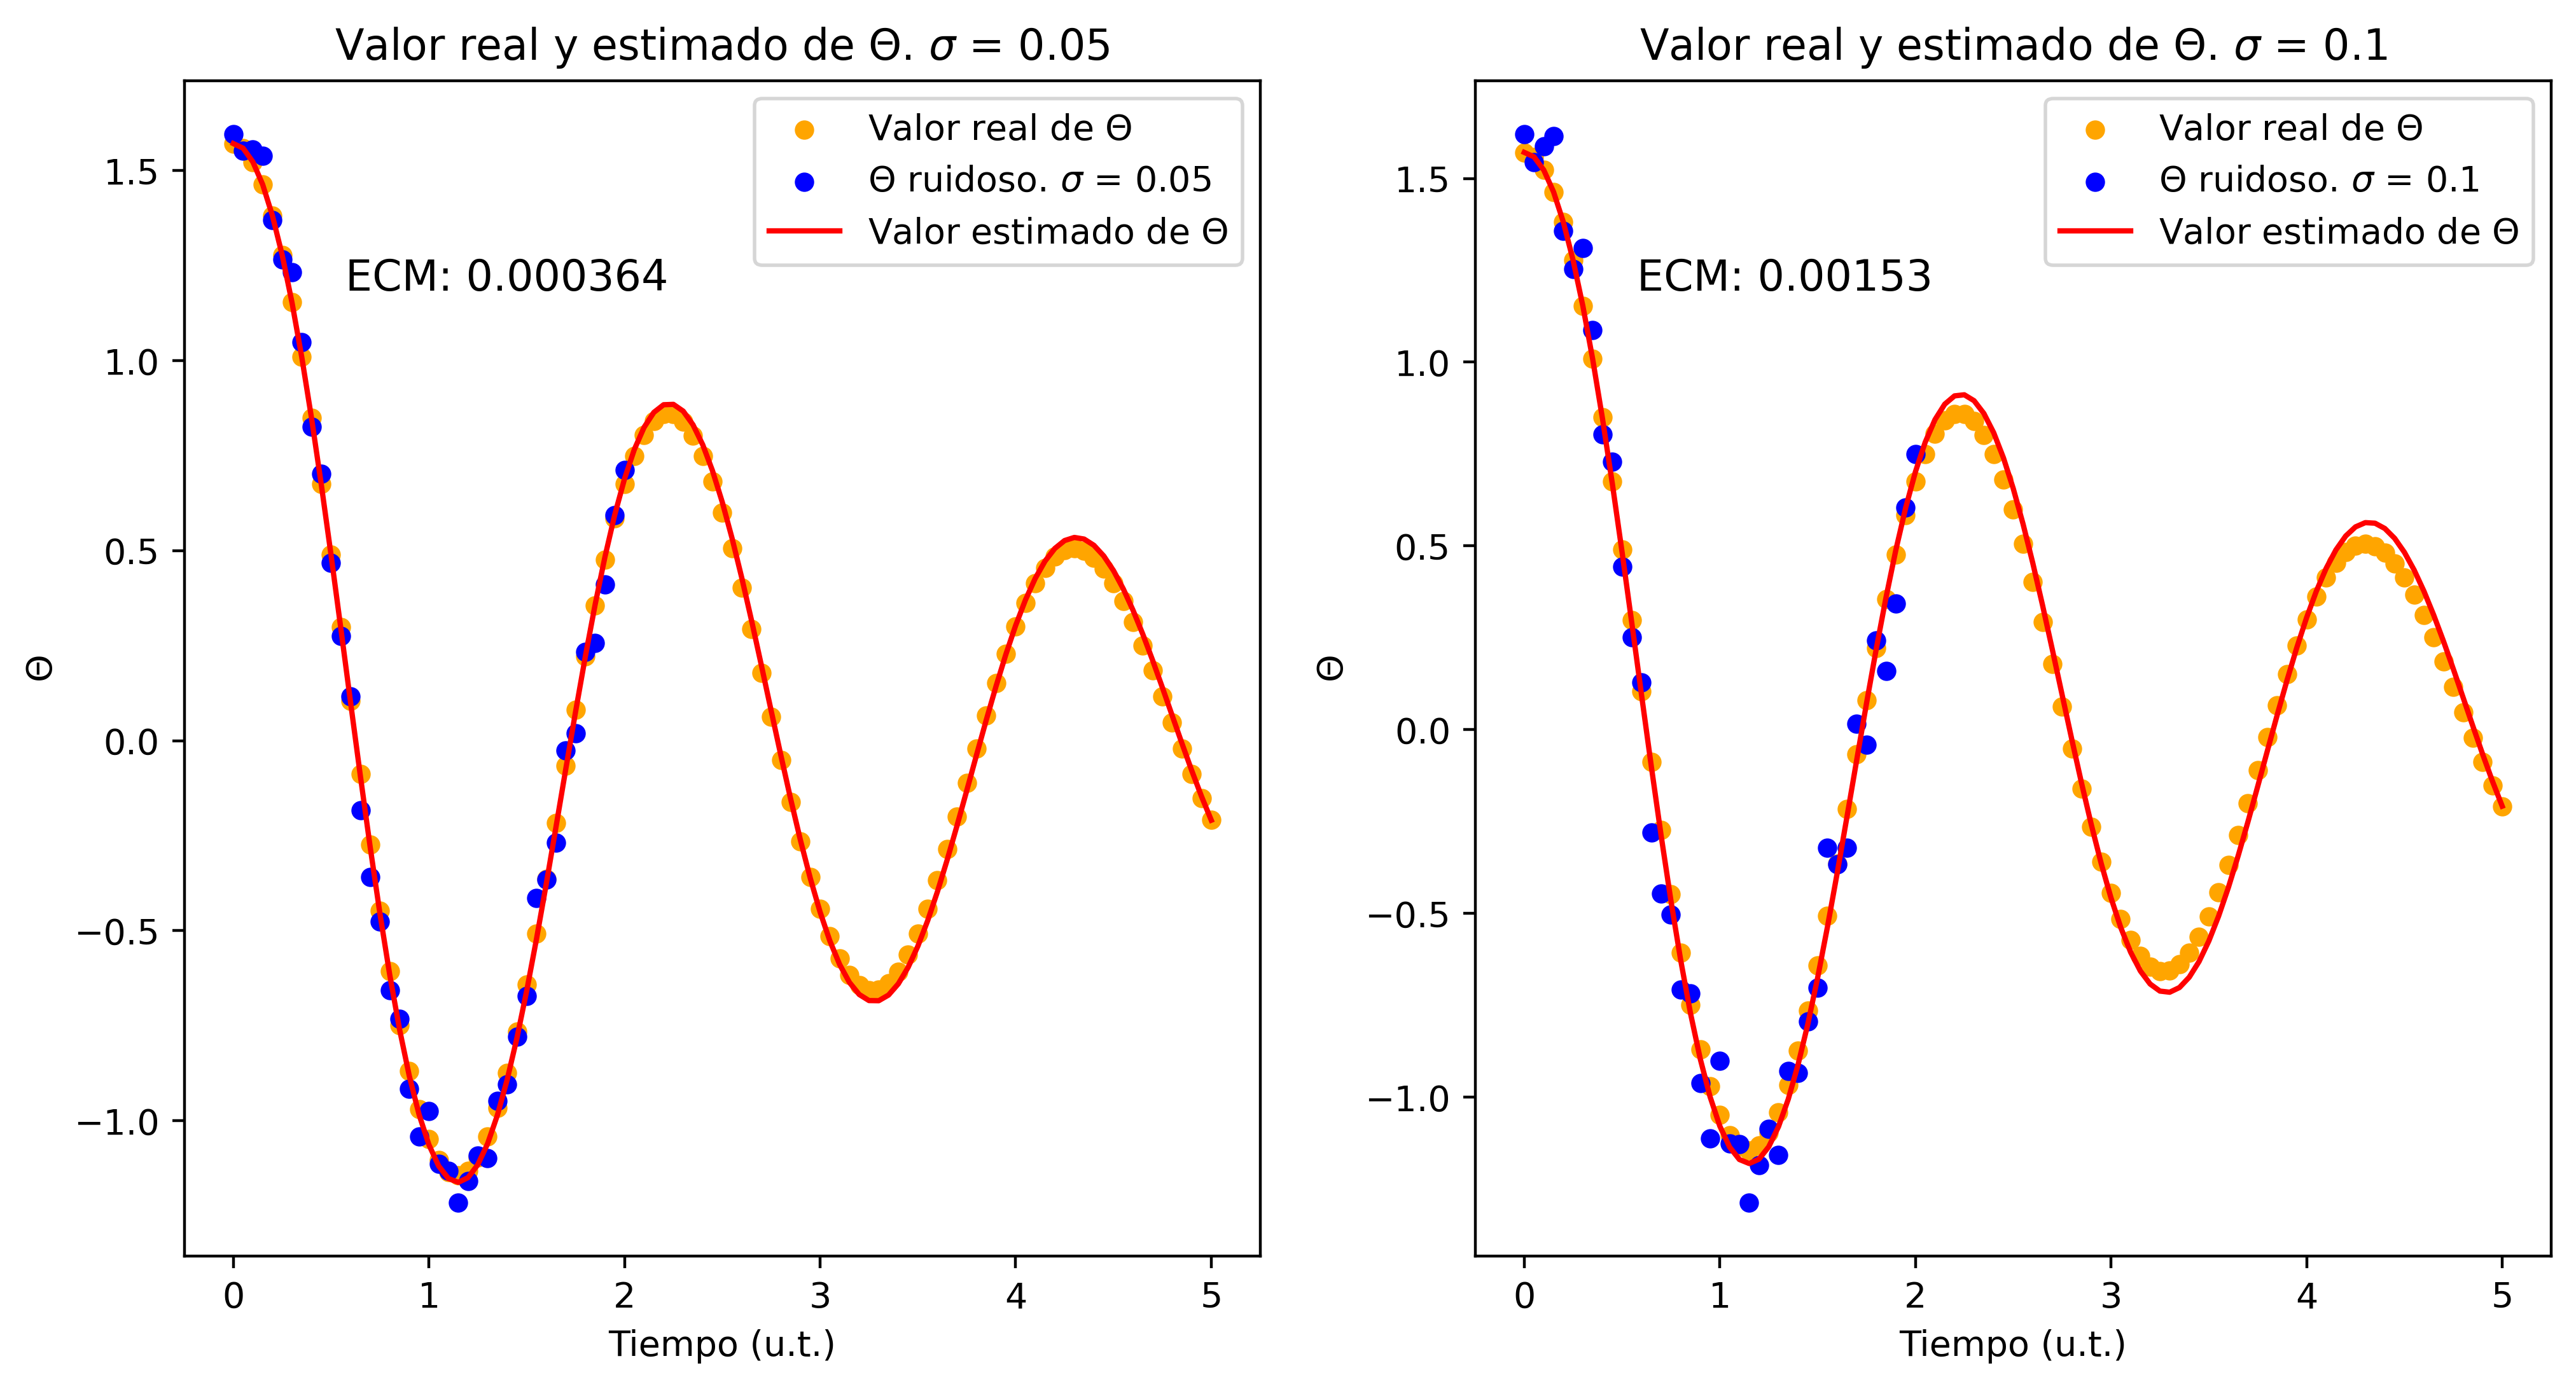

In [37]:
# Plot the results
plt.figure(figsize=(12, 6), dpi=400)
plt.subplot(1, 2, 1)
plt.scatter(t, actual_theta[:, 0], label=r'Valor real de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train05[:, 0], label=r'$\Theta$ ruidoso. $\sigma$ = 0.05', s=20, color = 'blue')
plt.plot(t, estimated_theta05[:, 0], label=r'Valor estimado de $\Theta$', color='red')
mse_01 = np.mean((actual_theta[:, 0] - estimated_theta05[:, 0]) ** 2)
plt.text(0.15, 0.85, f'ECM: {mse_01:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.title(r'Valor real y estimado de $\Theta$. $\sigma$ = 0.05')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.scatter(t, actual_theta[:, 0], label=r'Valor real de $\Theta$', s=20, color = 'orange')
plt.scatter(t_train, actual_theta_noisy_train10[:, 0], label=r'$\Theta$ ruidoso. $\sigma$ = 0.1', s=20, color = 'blue')
plt.plot(t, estimated_theta10[:, 0], label=r'Valor estimado de $\Theta$', color='red')
mse_02 = np.mean((actual_theta[:, 0] - estimated_theta10[:, 0]) ** 2)
plt.text(0.15, 0.85, f'ECM: {mse_02:.3}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.xlabel('Tiempo (u.t.)')
plt.ylabel(r'$\Theta$')
plt.legend()
plt.title(r'Valor real y estimado de $\Theta$. $\sigma$ = 0.1')
plt.grid(False)

plt.show()